In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import torch

nltk.download('punkt')

stemmer = PorterStemmer()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Initial EDA

In [2]:
total_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
total_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
total_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Initial EDA Findings:

    - There are 4 predictor variables and a binary response variable
    - The id preidctor can be dropped as it likely will provide no explanation towards the randomness in the response
    - The text predictor will likely provide the most explanatory power, but will require a lot of pre processing
    - The location and keyword variables have a lot of missing values and need some further investigation before using as input to a model

In [5]:
keyword_counts = total_df['keyword'].value_counts()
print(keyword_counts)

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64


In [6]:
def count_occurrences(df: pd.DataFrame, column_to_count: str) -> float:
    count = 0
    for index, row in df.iterrows():
        text = row['text']
        value = row[column_to_count]

        if value != np.nan and type(value) != float and value.lower() in text.lower():
            count += 1
    percentage = (count / len(df)) * 100
    return round(percentage, 3)

In [7]:
percentage_sentences_w_keyword = count_occurrences(total_df, 'keyword')
print(f"{percentage_sentences_w_keyword}% of text blocks have their keyword in them")

78.458% of text blocks have their keyword in them


In [8]:
location_counts = total_df['location'].value_counts()
print(location_counts)

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64


In [9]:
percentage_sentences_w_location = count_occurrences(total_df, 'location')
print(f"{percentage_sentences_w_location}% of text blocks have their location in them")

1.038% of text blocks have their location in them


In [10]:
location_counts = location_counts[location_counts > 5]
print(location_counts)

location
USA                  104
New York              71
United States         50
London                45
Canada                29
                    ... 
Oklahoma City, OK      6
Planet Earth           6
Massachusetts          6
Brooklyn, NY           6
Charlotte, NC          6
Name: count, Length: 76, dtype: int64


## Location & Keyword Findings

    - About 78% of the texts hold their keyword in them so this would likely provide redundant information
    - About 1% of the texts hold their location in them so this would be new information, but there are 3,341 unique values and a lot look to be useless
    - Therefore, I will leave these variables out of the model and attempt to train on the text variable exclusively

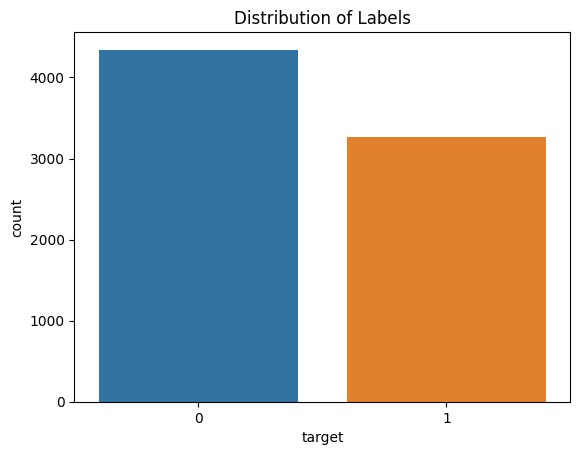

MLE of p: 0.4296597924602653


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=total_df)
plt.title("Distribution of Labels")
plt.show()

print(f"MLE of p: {total_df['target'].mean()}")

## Response Distribution

    - The bernoulli distribution in this training set is skewed towards 0, with the MLE of p = .4297
    - I'll rescale the loss weight associated with positive label type to account for the unbalanced dataset.
    - A postive label loss weight of (1 - .4297) / .4297 will make updates to misclassified positive inputs be weighted heavier.

In [12]:
POS_WEIGHT = (1 - total_df['target'].mean()) / total_df['target'].mean()
print(f"POSITIVE LABEL LOSS WEIGHT: {POS_WEIGHT}")

POSITIVE LABEL LOSS WEIGHT: 1.3274228064811986


## Preprocessing Text

    - I found some great functions for cleaning text on other work
    - The preprocessing work includes:
        - lowering text
        - removing punctuation
        - removing urls
        - removing brackets
        - removing newline
        - removing digits
        - removing emojis
    - Tokenize the cleaned text
    - After all the above is removed, I use a porter stemmer to replace words to their stemmed version

In [13]:
#Function from https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm#EDA-and-Preprocessing
def clean_text(text: str):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
#Function from https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#3.-Data-Pre-processing-%F0%9F%9B%A0
def remove_emoji(text: str):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
def preprocess_text(text: str) -> list[str]:
    text = clean_text(text)
    text = remove_emoji(text)
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop]
    return stemmed_words

In [16]:
total_df['cleaned_text'] = total_df["text"].apply(lambda x: preprocess_text(x))

total_df['cleaned_text'].head(5)

0    [deed, reason, earthquak, may, allah, forgiv, us]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, shelter, place, notifi, offic, ev...
3    [peopl, receiv, wildfir, evacu, order, califor...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
Name: cleaned_text, dtype: object

## Embeddings

    - Will use Stanford's 100 dimensional GloVe embeddings to convert cleaned tokens into numerical embeddings
    - This task requires a glove embedding lookup table(represented with a dictionary) and a vocabulary that maps the training set's unique tokens to unique indices
    - NOTE: An unknown token, '<UNK>' is used to map tokens unknown to Stanford's glove model or unseen tokens at inference time.
    - The embedding matrix will be of shape (len_of_vocab, embedding_dimension). 
    - The matrix formation utilizes the vocab to store each unique token's GloVe embedding at it's designated row index(as denoted by the vocabulary).
    - The vocabulary will be used on forward pass to feed row indices into the embedding matrix. The row indices will mimic multiplying the matrix by a one hot encoded vecotr. I.e., this will extract the necessary embedding row for downstream operations

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-10-12 17:21:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-12 17:21:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-12 17:21:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [18]:
glove_dict: dict = {}
embedding_dimension = 100

with open(f'/kaggle/working/glove.6B.{embedding_dimension}d.txt') as embedding_file:
    for line in embedding_file.readlines():
        records = line.split()
        word = records[0]
        glove_embedding = np.asarray(records[1:], dtype='float32')
        glove_dict[word] = glove_embedding


In [19]:
UNKNOWN_TOKEN = '<UNK>'
def build_vocab(corpus: pd.Series):
    vocab = {UNKNOWN_TOKEN: 0}
    for sentence_tokens in corpus:
        for word in sentence_tokens:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

In [20]:
def create_embedding_matrix(vocab: dict[str:int], glove_dict: dict[str:np.array], embedding_dimension: int):
    embedding_matrix = np.zeros((len(vocab), embedding_dimension))
    for word, idx in vocab.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            # Use a random vector for unknown words ~ drawing from standard normal distrubtion at each dimension
            embedding_matrix[idx] = np.random.normal(loc=0.0, scale=1.0, size=(embedding_dimension,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [21]:
VOCAB = build_vocab(total_df['cleaned_text'])

EMBEDDING_MATRIX = create_embedding_matrix(VOCAB, glove_dict, embedding_dimension)

## Abstracting data with Pytorch Dataset & DataLoader

    - Subclassing Pytorch's Dataset and passing to DataLoader allows for easy neural network operations
    - Subclassing the Dataset Class in this case means I can get the required indices for network input(discussed above under 'Embeddings Section'). I can also transform the inference text at runtime by passing a transform function
    - The DataLoader allows easy batching for training or inference. 
    - The DataLoader offers several optimizations like pinning paged memory for batches, prefetching batches during forward pass, persistent processes, and distributed work with num_workers
    - NOTE: The collate_fn of DataLoader is necessary for batching this NLP task. The batch input needs a matching length dimension for matrix operations so the collate_fn is used for padding the batch texts here

In [22]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: dict[str:int], unknown_token: str, text_col: str, target_col: str = None, transform=None):
        self.df = df
        self.vocab = vocab
        self.unknown_token = unknown_token
        self.text_col = text_col
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens = self.df.iloc[idx][self.text_col]
        target = self.df.iloc[idx][self.target_col]
        if self.transform:
            tokens = self.transform(tokens)
            
        indices = [self.vocab.get(token, self.vocab.get(self.unknown_token)) for token in tokens]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(target, dtype=torch.float32)

In [23]:
from sklearn.model_selection import train_test_split

subset_train_df = total_df[['cleaned_text', 'target']]
train_df, val_df = train_test_split(subset_train_df, test_size=0.1, random_state=11)

train_df.head(5)

print(f"NUM TRAINING SAMPLES: {len(train_df)}\nNUM VALIDATION SAMPLES: {len(val_df)}")

NUM TRAINING SAMPLES: 6851
NUM VALIDATION SAMPLES: 762


In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_fn(batch):
    sentences, labels = zip(*batch)
    padded_batch = pad_sequence(sentences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return padded_batch, labels

In [25]:
train_ds = TextDataset(df=train_df, vocab=VOCAB, unknown_token=UNKNOWN_TOKEN, text_col='cleaned_text', target_col='target')
val_ds = TextDataset(df=val_df, vocab=VOCAB, unknown_token=UNKNOWN_TOKEN, text_col='cleaned_text', target_col='target')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn,
                       num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

## Bidirectional LSTM
    
    - An LSTM is perfect for this NLP task because its recurrent structure allows for vairbale input length. I.e. sentences can have varying token length and the model architecture can still classify each.
    - Bidirectional allows 2 different sets of states to be retained as the input is processed in both directions simultaneously. This aspect of the architecture provides a more robust model, especially for a classfication task.
    - The GloVe embedding matrix will be finetuned based on my vocabulary, which research has shown to be very successful in NLP tasks.
    - After the LSTM forward pass, the bidirectional results are combined and batch normalized before going to a fully connected neural network.
    - Batch Norm allows faster convergence because weight updates aren't too large and creates a more robust model because inputs to downstream layers will all be from the standard normal distribution.
    - The fully connected layers utilize ReLU for non-linearity, a crucial part of the universal approximation theorem that makes neural networks so popular. 
    - Finally, a sigmoid function is applied to get an ouptut in (0, 1) interval. 
    - NOTE: A threshold of .5 will be used for classification because I have addressed class imbalance with the loss function postive weight(discussed under 'Response Distribution' Section).

In [26]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=True, batch_first=True)
        
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 25)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(25)
        
        self.fc2 = nn.Linear(25, 10)
        self.batch_norm3 = nn.BatchNorm1d(10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        
        out = self.batch_norm1(out)
        out = self.relu(self.fc(out))
        out = self.dropout(out)
        
        out = self.batch_norm2(out)
        out = self.relu(self.fc2(out))
        out = self.batch_norm3(out)
        
        out = self.sigmoid(self.fc3(out))
        return out


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
    
    def forward(self, output, target):
        loss = - self.pos_weight * target * torch.log(output) - (1 - target) * torch.log(1 - output)
        return loss.mean()

In [29]:
import torch.optim as optim

epochs = 10
learning_rate = .0005
criterion = WeightedBCELoss(POS_WEIGHT)

In [30]:
from tqdm import tqdm

In [31]:
delta = .0075
patience = 4
best_val_acc = 0

## Training Function

    - Use SGD w/ Adam to update weights over several epochs of training
    - Utilize early stopping against a validation dataset to monitor generalization capabilities and stop training after signs of overfitting
    - Save the model's weights after epoch if it has performed the best. Best meaning validation set accuracy is the highest seen across epochs.
    - The model's weights are updated in place, so only the best validation accuracy needs to be returned for reporting

In [32]:
def trainer_run(model: nn.Module, optimizer, train_loader: DataLoader, val_loader: DataLoader, device, epochs: int=10) -> float:
    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
    
        train_loss = 0.0
        train_correct = 0
        train_total = 0
    
        train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
        for idxs, labels in train_loader:
            idxs, labels = idxs.to(device), labels.to(device).unsqueeze(1)
        
            optimizer.zero_grad()
            outputs = model(idxs)
        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()
            train_loader.set_postfix(loss=train_loss/len(train_loader))
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    
        model.eval()
    
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for idxs, labels in val_loader:
                idxs, labels = idxs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(idxs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
        if (val_acc - best_val_acc) <= delta and (patience):
            break
        elif val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/current_lstm_model.pth')
            
    return best_val_acc

## Hyperparameter Grid Search

    - This is a fairly dated hyperparameter tuning method compared to bayesian tuning or frameworks like RayTune, but it still allows comparing across hyperparameter sets on limited available compute.
    - Combinations of hidden_size (the latent dimension of the LSTM internal states), number of layers in each direction of LSTM, and dropout rates are used to train. The best validation accuracy is maintained and used to keep track of the corresponding model hyperparameters
    - NOTE: embedding_dict is a dictionary and used to initialize the weights of the embedding layer in the model. I beleive this may update the matrix in place so I have created a new embedding matrix for each model during the search loop

In [33]:
hidden_sizes = [32, 64, 128]
num_layers = [2,3,4,5]
dropout_rates= [.2, .3]

best_acc = 0.0
best_model = None
best_hyperparameter_set = tuple()

for hidden_size in hidden_sizes:
    for num_layer in num_layers:
        for dropout_rate in dropout_rates:
            current_embed_matrix = create_embedding_matrix(VOCAB, glove_dict, embedding_dimension)
            current_model = BiLSTMClassifier(embedding_matrix=current_embed_matrix, hidden_size=hidden_size, num_layers=num_layer, dropout=dropout_rate)
            current_model.to(device)
            
            optimizer = optim.Adam(current_model.parameters(), lr=learning_rate)
            
            print(f"----- Training w/ hidden_sz: {hidden_size}, num_layer: {num_layer}, d_r: {dropout_rate} -----")
            current_acc = trainer_run(current_model, optimizer, train_loader, val_loader, device)
            
            if current_acc > best_acc:
                best_acc = current_acc
                
                best_hyperparameter_set = (hidden_size, num_layer, dropout_rate)
                current_model.load_state_dict(torch.load('/kaggle/working/current_lstm_model.pth', weights_only=True))
                torch.save(current_model.state_dict(), '/kaggle/working/best_lstm_model.pth')
                best_model = current_model
                
            print("\n\n\n")
            

----- Training w/ hidden_sz: 32, num_layer: 2, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7489, Training Accuracy: 0.6062, Validation Loss: 0.6750, Validation Accuracy: 0.6903


Epoch 2/10, Training Loss: 0.6186, Training Accuracy: 0.7371, Validation Loss: 0.6101, Validation Accuracy: 0.7310


Epoch 3/10, Training Loss: 0.5383, Training Accuracy: 0.7980, Validation Loss: 0.5686, Validation Accuracy: 0.7848


Epoch 4/10, Training Loss: 0.4849, Training Accuracy: 0.8285, Validation Loss: 0.5651, Validation Accuracy: 0.7677




----- Training w/ hidden_sz: 32, num_layer: 2, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7728, Training Accuracy: 0.5751, Validation Loss: 0.7133, Validation Accuracy: 0.6942


Epoch 2/10, Training Loss: 0.6524, Training Accuracy: 0.7190, Validation Loss: 0.6101, Validation Accuracy: 0.7651


Epoch 3/10, Training Loss: 0.5646, Training Accuracy: 0.7878, Validation Loss: 0.6074, Validation Accuracy: 0.7795


Epoch 4/10, Training Loss: 0.5019, Training Accuracy: 0.8240, Validation Loss: 0.5984, Validation Accuracy: 0.7717




----- Training w/ hidden_sz: 32, num_layer: 3, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7365, Training Accuracy: 0.5888, Validation Loss: 0.6801, Validation Accuracy: 0.6220


Epoch 2/10, Training Loss: 0.5982, Training Accuracy: 0.7484, Validation Loss: 0.5829, Validation Accuracy: 0.7454


Epoch 3/10, Training Loss: 0.5190, Training Accuracy: 0.8035, Validation Loss: 0.6220, Validation Accuracy: 0.7612


Epoch 4/10, Training Loss: 0.4565, Training Accuracy: 0.8355, Validation Loss: 0.5476, Validation Accuracy: 0.7730


Epoch 5/10, Training Loss: 0.4012, Training Accuracy: 0.8656, Validation Loss: 0.5661, Validation Accuracy: 0.7638




----- Training w/ hidden_sz: 32, num_layer: 3, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7290, Training Accuracy: 0.6380, Validation Loss: 0.6348, Validation Accuracy: 0.7375


Epoch 2/10, Training Loss: 0.5881, Training Accuracy: 0.7616, Validation Loss: 0.6184, Validation Accuracy: 0.6864




----- Training w/ hidden_sz: 32, num_layer: 4, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7251, Training Accuracy: 0.5998, Validation Loss: 0.6248, Validation Accuracy: 0.7205


Epoch 2/10, Training Loss: 0.5816, Training Accuracy: 0.7564, Validation Loss: 0.5681, Validation Accuracy: 0.7585


Epoch 3/10, Training Loss: 0.5058, Training Accuracy: 0.8111, Validation Loss: 0.5326, Validation Accuracy: 0.7992


Epoch 4/10, Training Loss: 0.4484, Training Accuracy: 0.8424, Validation Loss: 0.6430, Validation Accuracy: 0.6824




----- Training w/ hidden_sz: 32, num_layer: 4, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7377, Training Accuracy: 0.6009, Validation Loss: 0.6521, Validation Accuracy: 0.7165


Epoch 2/10, Training Loss: 0.5923, Training Accuracy: 0.7630, Validation Loss: 0.5639, Validation Accuracy: 0.7730


Epoch 3/10, Training Loss: 0.5189, Training Accuracy: 0.8133, Validation Loss: 0.6396, Validation Accuracy: 0.6772




----- Training w/ hidden_sz: 32, num_layer: 5, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7174, Training Accuracy: 0.6570, Validation Loss: 0.6692, Validation Accuracy: 0.6824


Epoch 2/10, Training Loss: 0.5694, Training Accuracy: 0.7770, Validation Loss: 0.5350, Validation Accuracy: 0.7913


Epoch 3/10, Training Loss: 0.5045, Training Accuracy: 0.8110, Validation Loss: 0.5325, Validation Accuracy: 0.7861




----- Training w/ hidden_sz: 32, num_layer: 5, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7617, Training Accuracy: 0.6139, Validation Loss: 0.6673, Validation Accuracy: 0.6942


Epoch 2/10, Training Loss: 0.6306, Training Accuracy: 0.7338, Validation Loss: 0.7437, Validation Accuracy: 0.5958




----- Training w/ hidden_sz: 64, num_layer: 2, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7409, Training Accuracy: 0.6358, Validation Loss: 0.6464, Validation Accuracy: 0.7218


Epoch 2/10, Training Loss: 0.5998, Training Accuracy: 0.7619, Validation Loss: 0.6268, Validation Accuracy: 0.7047




----- Training w/ hidden_sz: 64, num_layer: 2, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7506, Training Accuracy: 0.6288, Validation Loss: 0.6578, Validation Accuracy: 0.7283


Epoch 2/10, Training Loss: 0.6062, Training Accuracy: 0.7542, Validation Loss: 0.5848, Validation Accuracy: 0.7848


Epoch 3/10, Training Loss: 0.5300, Training Accuracy: 0.7993, Validation Loss: 0.5669, Validation Accuracy: 0.7677




----- Training w/ hidden_sz: 64, num_layer: 3, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.7063, Training Accuracy: 0.6456, Validation Loss: 0.5901, Validation Accuracy: 0.7520


Epoch 2/10, Training Loss: 0.5729, Training Accuracy: 0.7733, Validation Loss: 0.5538, Validation Accuracy: 0.7874


Epoch 3/10, Training Loss: 0.5017, Training Accuracy: 0.8145, Validation Loss: 0.5368, Validation Accuracy: 0.7782




----- Training w/ hidden_sz: 64, num_layer: 3, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7045, Training Accuracy: 0.6817, Validation Loss: 0.6037, Validation Accuracy: 0.7612


Epoch 2/10, Training Loss: 0.5667, Training Accuracy: 0.7865, Validation Loss: 0.6156, Validation Accuracy: 0.7060




----- Training w/ hidden_sz: 64, num_layer: 4, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6831, Training Accuracy: 0.6913, Validation Loss: 0.5881, Validation Accuracy: 0.7690


Epoch 2/10, Training Loss: 0.5644, Training Accuracy: 0.7863, Validation Loss: 0.5396, Validation Accuracy: 0.7861


Epoch 3/10, Training Loss: 0.4949, Training Accuracy: 0.8196, Validation Loss: 0.5259, Validation Accuracy: 0.7913




----- Training w/ hidden_sz: 64, num_layer: 4, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7037, Training Accuracy: 0.6333, Validation Loss: 0.5897, Validation Accuracy: 0.7388


Epoch 2/10, Training Loss: 0.5638, Training Accuracy: 0.7767, Validation Loss: 0.5533, Validation Accuracy: 0.7874


Epoch 3/10, Training Loss: 0.4938, Training Accuracy: 0.8208, Validation Loss: 0.5227, Validation Accuracy: 0.7992


Epoch 4/10, Training Loss: 0.4405, Training Accuracy: 0.8447, Validation Loss: 0.5311, Validation Accuracy: 0.8045




----- Training w/ hidden_sz: 64, num_layer: 5, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6934, Training Accuracy: 0.6850, Validation Loss: 0.6002, Validation Accuracy: 0.7677


Epoch 2/10, Training Loss: 0.5596, Training Accuracy: 0.7780, Validation Loss: 0.5390, Validation Accuracy: 0.7703




----- Training w/ hidden_sz: 64, num_layer: 5, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.6817, Training Accuracy: 0.6884, Validation Loss: 0.5653, Validation Accuracy: 0.7822


Epoch 2/10, Training Loss: 0.5467, Training Accuracy: 0.7881, Validation Loss: 0.5457, Validation Accuracy: 0.7927


Epoch 3/10, Training Loss: 0.4929, Training Accuracy: 0.8210, Validation Loss: 0.5423, Validation Accuracy: 0.7756




----- Training w/ hidden_sz: 128, num_layer: 2, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6875, Training Accuracy: 0.6925, Validation Loss: 0.5760, Validation Accuracy: 0.7638


Epoch 2/10, Training Loss: 0.5605, Training Accuracy: 0.7863, Validation Loss: 0.5424, Validation Accuracy: 0.7756


Epoch 3/10, Training Loss: 0.5010, Training Accuracy: 0.8094, Validation Loss: 0.5301, Validation Accuracy: 0.7979


Epoch 4/10, Training Loss: 0.4451, Training Accuracy: 0.8435, Validation Loss: 0.5408, Validation Accuracy: 0.8110


Epoch 5/10, Training Loss: 0.4099, Training Accuracy: 0.8562, Validation Loss: 0.5261, Validation Accuracy: 0.7927




----- Training w/ hidden_sz: 128, num_layer: 2, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7341, Training Accuracy: 0.6253, Validation Loss: 0.7332, Validation Accuracy: 0.5919


Epoch 2/10, Training Loss: 0.6077, Training Accuracy: 0.7437, Validation Loss: 0.5701, Validation Accuracy: 0.7585


Epoch 3/10, Training Loss: 0.5288, Training Accuracy: 0.7973, Validation Loss: 0.5376, Validation Accuracy: 0.7795


Epoch 4/10, Training Loss: 0.4691, Training Accuracy: 0.8297, Validation Loss: 0.5402, Validation Accuracy: 0.7782




----- Training w/ hidden_sz: 128, num_layer: 3, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6681, Training Accuracy: 0.7053, Validation Loss: 0.5737, Validation Accuracy: 0.7730


Epoch 2/10, Training Loss: 0.5610, Training Accuracy: 0.7794, Validation Loss: 0.5417, Validation Accuracy: 0.7822


Epoch 3/10, Training Loss: 0.4920, Training Accuracy: 0.8203, Validation Loss: 0.5269, Validation Accuracy: 0.7992


Epoch 4/10, Training Loss: 0.4408, Training Accuracy: 0.8415, Validation Loss: 0.5542, Validation Accuracy: 0.7572




----- Training w/ hidden_sz: 128, num_layer: 3, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.6984, Training Accuracy: 0.6808, Validation Loss: 0.6094, Validation Accuracy: 0.7703


Epoch 2/10, Training Loss: 0.5607, Training Accuracy: 0.7898, Validation Loss: 0.5373, Validation Accuracy: 0.7953


Epoch 3/10, Training Loss: 0.5035, Training Accuracy: 0.8180, Validation Loss: 0.5447, Validation Accuracy: 0.7769




----- Training w/ hidden_sz: 128, num_layer: 4, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6668, Training Accuracy: 0.7033, Validation Loss: 0.5776, Validation Accuracy: 0.7520


Epoch 2/10, Training Loss: 0.5490, Training Accuracy: 0.7884, Validation Loss: 0.5424, Validation Accuracy: 0.7795


Epoch 3/10, Training Loss: 0.4884, Training Accuracy: 0.8232, Validation Loss: 0.5205, Validation Accuracy: 0.7953


Epoch 4/10, Training Loss: 0.4404, Training Accuracy: 0.8463, Validation Loss: 0.5882, Validation Accuracy: 0.7638




----- Training w/ hidden_sz: 128, num_layer: 4, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.7161, Training Accuracy: 0.6608, Validation Loss: 0.6133, Validation Accuracy: 0.7415


Epoch 2/10, Training Loss: 0.5875, Training Accuracy: 0.7647, Validation Loss: 0.5780, Validation Accuracy: 0.7428




----- Training w/ hidden_sz: 128, num_layer: 5, d_r: 0.2 -----


Epoch 1/10, Training Loss: 0.6630, Training Accuracy: 0.6876, Validation Loss: 0.5751, Validation Accuracy: 0.7835


Epoch 2/10, Training Loss: 0.5528, Training Accuracy: 0.7805, Validation Loss: 0.5557, Validation Accuracy: 0.7979


Epoch 3/10, Training Loss: 0.4977, Training Accuracy: 0.8219, Validation Loss: 0.5727, Validation Accuracy: 0.7625




----- Training w/ hidden_sz: 128, num_layer: 5, d_r: 0.3 -----


Epoch 1/10, Training Loss: 0.6638, Training Accuracy: 0.6784, Validation Loss: 0.5906, Validation Accuracy: 0.7690


Epoch 2/10, Training Loss: 0.5681, Training Accuracy: 0.7679, Validation Loss: 0.5659, Validation Accuracy: 0.7769


Epoch 3/10, Training Loss: 0.4918, Training Accuracy: 0.8161, Validation Loss: 0.5354, Validation Accuracy: 0.7900


Epoch 4/10, Training Loss: 0.4443, Training Accuracy: 0.8405, Validation Loss: 0.5458, Validation Accuracy: 0.7769






In [34]:
print(f"BEST HYPERPARAMETER SET:\nhidden_sz: {best_hyperparameter_set[0]} num_layers: {best_hyperparameter_set[1]} d_r:{best_hyperparameter_set[2]}\nWITH VAL ACCURACY: {best_acc}")

BEST HYPERPARAMETER SET:
hidden_sz: 128 num_layers: 2 d_r:0.2
WITH VAL ACCURACY: 0.8110236220472441


## Best Model

    - Best model has latent dimension of 64 in internal LSTM states, 3 layers in each direction of LSTM, and dropout rate of .2 for each layer in fully connected neural network.
    - The best validation accuracy was 80.18%
    - Now show confusion matrix and f1 score of this model

In [35]:
def inference(model, data_loader, device) -> list[int]:
    best_model.eval()
    predictions = []

    for idx, _ in data_loader:
        idx = idx.to(device)
        outputs = best_model(idx)
            
        predicted = (outputs > 0.5).int().reshape(-1)
        predictions.extend(predicted.cpu().numpy())
        
    return predictions

In [36]:
validation_predictions = inference(best_model, val_loader, device)

F1 SCORE: 0.7669902912621359


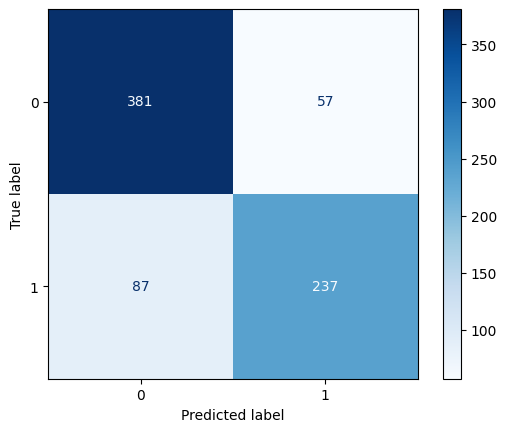

In [37]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f1 = f1_score(val_df['target'], validation_predictions)
print(f"F1 SCORE: {f1}")

cm = confusion_matrix(val_df['target'], validation_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)


## Submission
    
    - Reuse custom Dataset, DataLoader, and the best model from grid search to perform inference against the test set

In [38]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
submission_df = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

print(test_df.head(5))

print(submission_df.head(5))

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


In [39]:
test_ds = TextDataset(df=test_df, vocab=VOCAB, unknown_token=UNKNOWN_TOKEN, text_col='text', target_col='id', transform=preprocess_text)

test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [40]:
test_predictions = inference(best_model, test_loader, device)

In [41]:
submission_df['target'] = test_predictions
submission_df.head(5)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [42]:
submission_df.to_csv('submission.csv', index=False)